<a href="https://colab.research.google.com/github/andy258741/NCHU_Finance/blob/main/7112029030_w9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 獲取大立光整年資料

In [1]:
import requests
import pandas as pd
from datetime import datetime

# 將民國年轉換為西元年
def convert_date(date_str):
    year, month, day = date_str.split('/')
    year = str(int(year) + 1911)  # 民國年轉西元年
    return f"{year}/{month}/{day}"

def fetch_monthly_data(stock_no, year, month):
    # 定義日期，使用每月的第一天作為請求參數
    date_str = f"{year}{month:02d}01"
    url = f"https://www.twse.com.tw/exchangeReport/STOCK_DAY?response=json&date={date_str}&stockNo={stock_no}"

    # 發送 API 請求
    response = requests.get(url)

    # 如果請求成功，返回JSON數據
    if response.status_code == 200:
        return response.json()
    else:
        return None

def fetch_yearly_data(stock_no, year):
    all_data = []

    for month in range(1, 13):  # 從1月到12月
        data = fetch_monthly_data(stock_no, year, month)
        if data and data['stat'] == 'OK':
            # 將每個月的數據添加到列表中
            all_data.extend(data['data'])

    # 將數據轉換為DataFrame，並指定欄位名稱
    df = pd.DataFrame(all_data, columns=["日期", "成交股數", "成交金額", "開盤價", "最高價", "最低價", "收盤價", "漲跌價差", "成交筆數"])

    # 全部換成float以利後續計算
    # 使用 applymap 將 replace 和 astype 應用於每個單元格
    for col in ["成交股數", "成交金額", "開盤價", "最高價", "最低價", "收盤價", "成交筆數"]:
        df[col] = df[col].astype(str).str.replace(",", "").astype(float)

    # 將日期從民國年轉換為西元年格式
    df['日期'] = df['日期'].apply(convert_date)

    # 將日期欄位轉換為datetime格式，並重新排序數據
    df['日期'] = pd.to_datetime(df['日期'], format='%Y/%m/%d')
    df = df.sort_values(by='日期').reset_index(drop=True)

    return df

# 查詢大立光 (3008) 在 2024 年的收盤價
stock_no = '3008'
year = 2024

# 獲取一整年的數據
df = fetch_yearly_data(stock_no, year)

# 查看一整年每日交易資料
df

,日期,成交股數,成交金額,開盤價,最高價,最低價,收盤價,漲跌價差,成交筆數
0,2024-01-02,1255925.0,3.492707e+09,2860.0,2860.0,2745.0,2785.0,-85.00,6197.0
1,2024-01-03,1426707.0,3.836737e+09,2725.0,2730.0,2665.0,2685.0,-100.00,6281.0
2,2024-01-04,980717.0,2.608750e+09,2680.0,2710.0,2640.0,2650.0,-35.00,3239.0
3,2024-01-05,1271931.0,3.328926e+09,2640.0,2675.0,2585.0,2595.0,-55.00,5751.0
4,2024-01-08,1004026.0,2.592676e+09,2600.0,2620.0,2550.0,2580.0,-15.00,4016.0
...,...,...,...,...,...,...,...,...,...
200,2024-11-04,572600.0,1.331210e+09,2300.0,2350.0,2275.0,2340.0,+50.00,2593.0
201,2024-11-05,316877.0,7.346529e+08,2310.0,2330.0,2310.0,2320.0,-20.00,2087.0
202,2024-11-06,476964.0,1.113731e+09,2325.0,2360.0,2315.0,2340.0,+20.00,1775.0
203,2024-11-07,269041.0,6.298092e+08,2340.0,2355.0,2330.0,2335.0,-5.00,1591.0


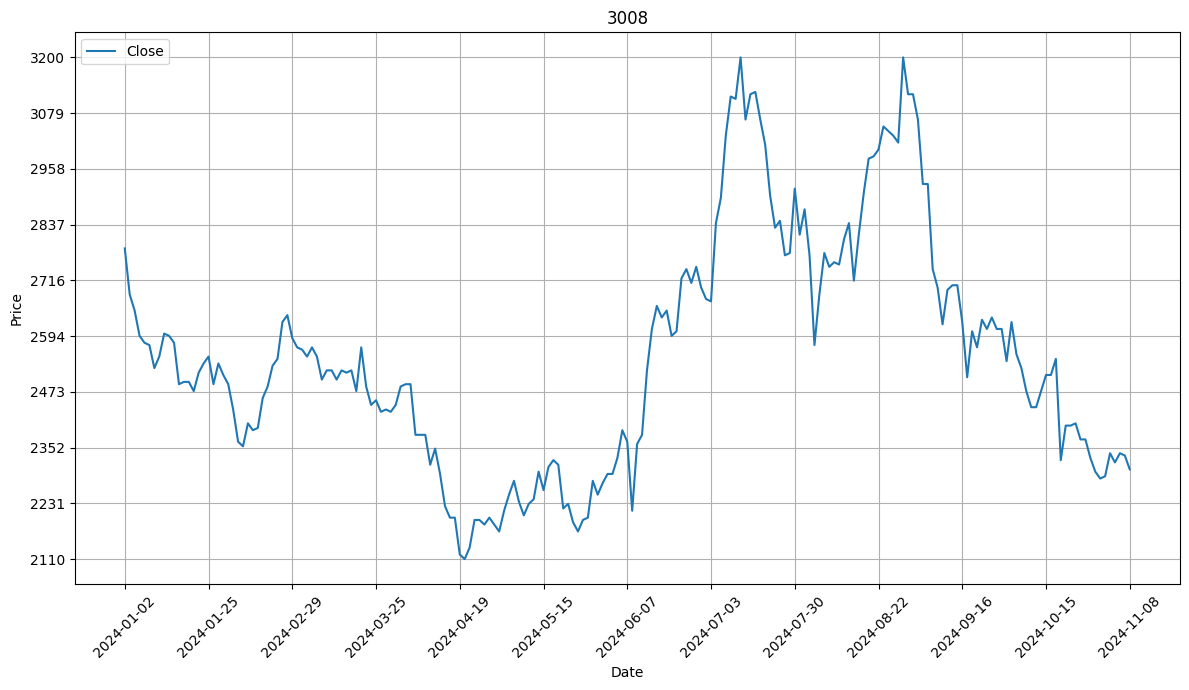

In [2]:
# 將收盤價可視化
import matplotlib.pyplot as plt
import numpy as np  # Import numpy for linspace

# 畫布尺寸大小設定
plt.figure(figsize=(12, 7))

# 設定要繪製的資料欄位
plt.plot(df['收盤價'], label='Close')

# 設定 x 軸的時間
num = 12
date = df["日期"].dt.strftime('%Y-%m-%d')
plt.xticks(date[::len(date)//num].index,
           date[::len(date)//num],
           rotation=45)

# 設定圖表的標題，x 軸和 y 軸的標籤
plt.title('3008')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.grid(True)

# 設定 y 軸刻度，平均間隔顯示十個數字
# Get the minimum and maximum values of the '收盤價' column
ymin = df['收盤價'].min()
ymax = df['收盤價'].max()

# Generate 10 evenly spaced values between ymin and ymax
yticks = np.linspace(ymin, ymax, 10)
# Set the y-axis ticks to the generated values
plt.yticks(yticks)

plt.tight_layout()

# 顯示圖表
plt.show()

# 作業1：使用 LSTM 模型預測股票未來價格，自訂窗口大小，並分析預測效果。

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 讀取數據
data = df[['收盤價']]  # 假設僅使用收盤價進行預測

# 將數據標準化到 [0, 1] 區間
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# 自訂窗口大小
window_size = 5

# 構建訓練數據集
def create_dataset(dataset, window_size):
    x, y = [], []
    for i in range(len(dataset) - window_size - 1):
        x.append(dataset[i:(i + window_size), 0])
        y.append(dataset[i + window_size, 0])
    return np.array(x), np.array(y)

x, y = create_dataset(data_scaled, window_size)

# 調整輸入形狀以符合 LSTM 的要求
x = np.reshape(x, (x.shape[0], x.shape[1], 1))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# 建立 LSTM 模型
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# 編譯模型
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# 訓練模型
history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - loss: 0.2259 - val_loss: 0.0868
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1299 - val_loss: 0.0351
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0564 - val_loss: 0.0052
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0209 - val_loss: 0.0343
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0287 - val_loss: 0.0424
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0235 - val_loss: 0.0130
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0153 - val_loss: 0.0052
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0179 - val_loss: 0.0048
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0152 - val_loss: 0.0082
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0124 - val_loss: 0.0143
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0115 - val_loss: 0.0137
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0107 - val_loss: 0.0096
Epoch 13/20

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


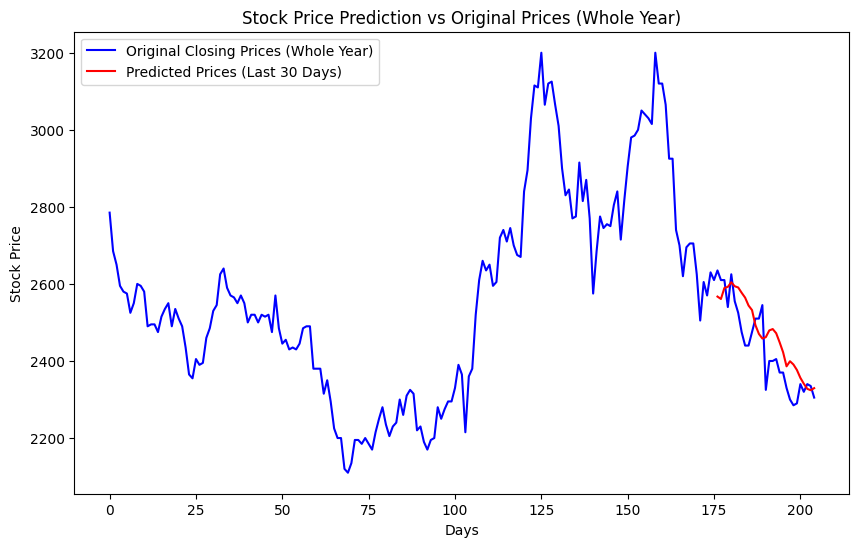

In [ ]:
# 構建測試數據
test_data = data_scaled[-(window_size + 30):]  # 使用最後一段數據進行測試
x_test, y_test = create_dataset(test_data, window_size)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# 進行預測
predicted_stock_price = model.predict(x_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

# 將真實價格轉換回原始尺度
y_test = scaler.inverse_transform([y_test])

# 可視化原始整年收盤價與預測結果
plt.figure(figsize=(10,6))

# 畫出整年的原始收盤價
plt.plot(data, label='Original Closing Prices (Whole Year)', color='blue')

# 畫出預測的折線圖，並與原始數據對齊
plt.plot(range(len(data) - len(predicted_stock_price), len(data)), predicted_stock_price, label='Predicted Prices (Last 30 Days)', color='red')

# 添加標籤和標題
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction vs Original Prices (Whole Year)')
plt.legend()

# 顯示圖表
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 計算誤差
mse = mean_squared_error(y_test[0], predicted_stock_price[:, 0])
mae = mean_absolute_error(y_test[0], predicted_stock_price[:, 0])

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')


Mean Squared Error (MSE): 4238.003303338747
Mean Absolute Error (MAE): 54.68465449892245


# 使用 Transformer 模型預測股價漲跌，自訂窗口大小，並分析預測結果。

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# 讀取數據
data = data[['收盤價']]

# 將數據標準化
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# 定義窗口大小
window_size = 5  # 和LSTM一樣設定5
x, y = [], []
for i in range(len(data_scaled) - window_size):
    x.append(data_scaled[i:i + window_size])
    y.append(data_scaled[i + window_size])

x, y = np.array(x), np.array(y)

# 將數據拆分為訓練集和測試集
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Layer

class PositionalEncoding(Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.position_encoding = self.positional_encoding(position, d_model)

    def get_config(self):
        return {"position": self.position_encoding.shape[0], "d_model": self.position_encoding.shape[1]}

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(np.arange(position)[:, np.newaxis],
                                     np.arange(d_model)[np.newaxis, :],
                                     d_model)

        # apply sin to even indices in the array; 2i
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

        # apply cos to odd indices in the array; 2i+1
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]

        return tf.cast(pos_encoding, dtype=tf.float32)

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
        return pos * angle_rates

    def call(self, inputs):
        return inputs + self.position_encoding[:, :tf.shape(inputs)[1], :]


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Embedding
from tensorflow.keras.models import Model

class TrainablePositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(TrainablePositionalEncoding, self).__init__()
        self.position_encoding = self.add_weight(
            name="position_encoding", # Explicitly name the argument as 'name'
            shape=(position, d_model), # Pass shape as a tuple
            initializer="random_normal",
            trainable=True
        )

    def call(self, inputs):
        return inputs + self.position_encoding[: tf.shape(inputs)[1], :]

def transformer_block(inputs, num_heads, ff_dim, dropout_rate=0.1):
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attention_output = Dropout(dropout_rate)(attention_output)
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output + inputs)

    ff_output = Dense(ff_dim, activation="relu")(attention_output)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    ff_output = Dropout(dropout_rate)(ff_output)
    return LayerNormalization(epsilon=1e-6)(ff_output + attention_output)

def build_deep_transformer_model(input_shape, num_heads=4, ff_dim=128, num_blocks=6, dropout_rate=0.05):
    inputs = Input(shape=input_shape)
    x = TrainablePositionalEncoding(input_shape[0], input_shape[1])(inputs)

    for _ in range(num_blocks):
        x = transformer_block(x, num_heads=num_heads, ff_dim=ff_dim, dropout_rate=dropout_rate)

    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.1)(x)  # 輕微的 Dropout 避免過擬合
    outputs = Dense(1, activation="linear")(x)
    return Model(inputs=inputs, outputs=outputs)

# 編譯和訓練模型
model = build_deep_transformer_model((window_size, 1))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mean_squared_error')

history = model.fit(x_train, y_train, epochs=500, batch_size=64, validation_split=0.2)


Epoch 1/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.2271 - val_loss: 0.1958
Epoch 2/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.2122 - val_loss: 0.1956
Epoch 3/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.2251 - val_loss: 0.1954
Epoch 4/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.2302 - val_loss: 0.1953
Epoch 5/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.2181 - val_loss: 0.1951
Epoch 6/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.2165 - val_loss: 0.1949
Epoch 7/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.2202 - val_loss: 0.1948
Epoch 8/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.2214 - val_loss: 0.1946
Epoch 9/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.2335 - val_loss: 0.1944
Epoch 10/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.2334 - val_loss: 0.1943
Epoch 11/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.2175 - val_loss: 0.1941
Epoch 12/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.2139 - val_los

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 850ms/step
Mean Squared Error (MSE): 156754.3631911874
Mean Absolute Error (MAE): 302.2193603515625


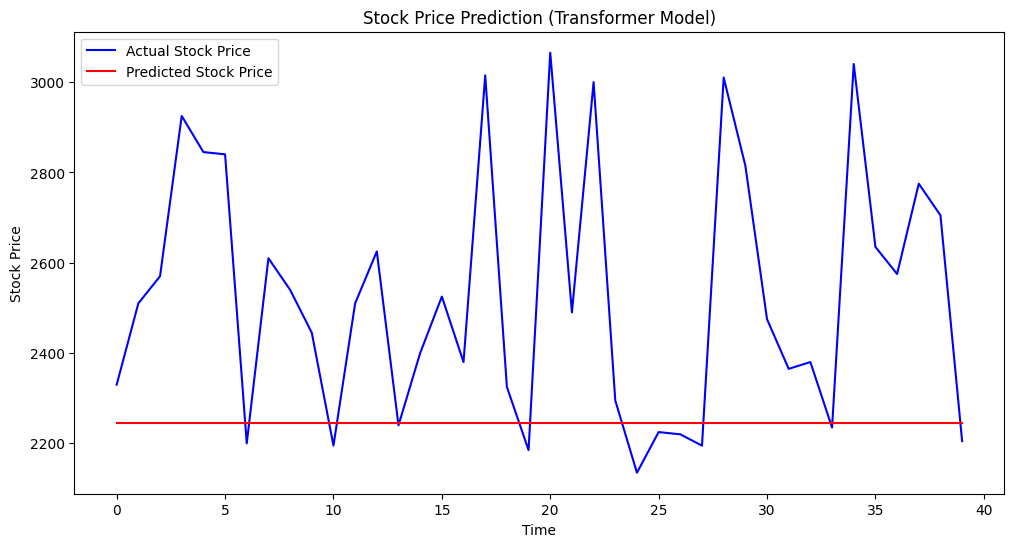

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# 預測測試集
y_pred = model.predict(x_test)
y_pred = scaler.inverse_transform(y_pred)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# 計算 MSE 和 MAE
mse = mean_squared_error(y_test_inverse, y_pred)
mae = mean_absolute_error(y_test_inverse, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')

# 可視化預測結果
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, color='blue', label='Actual Stock Price')
plt.plot(y_pred, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction (Transformer Model)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [6]:
# 各種參數都調整過了，但訓練效果依舊很差，想到的可能原因有二。第一，窗口的大小太小不利於注意力機制的使用；第二，訓練數據太少，Transformer訓練不起來。
# 模型複雜度暫不考慮，理論上一層的多頭注意力層應該是足夠了
# 因此我們調整窗口大小試試看，調成30看看
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# 讀取數據
data = data[['收盤價']]

# 將數據標準化
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# 定義窗口大小
window_size = 30  # 調整成30
x, y = [], []
for i in range(len(data_scaled) - window_size):
    x.append(data_scaled[i:i + window_size])
    y.append(data_scaled[i + window_size])

x, y = np.array(x), np.array(y)

# 將數據拆分為訓練集和測試集
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Embedding
from tensorflow.keras.models import Model

class TrainablePositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(TrainablePositionalEncoding, self).__init__()
        self.position_encoding = self.add_weight(
            name="position_encoding", # Explicitly name the argument as 'name'
            shape=(position, d_model), # Pass shape as a tuple
            initializer="random_normal",
            trainable=True
        )

    def call(self, inputs):
        return inputs + self.position_encoding[: tf.shape(inputs)[1], :]

def transformer_block(inputs, num_heads, ff_dim, dropout_rate=0.1):
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attention_output = Dropout(dropout_rate)(attention_output)
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output + inputs)

    ff_output = Dense(ff_dim, activation="relu")(attention_output)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    ff_output = Dropout(dropout_rate)(ff_output)
    return LayerNormalization(epsilon=1e-6)(ff_output + attention_output)

def build_deep_transformer_model(input_shape, num_heads=4, ff_dim=128, num_blocks=6, dropout_rate=0.05):
    inputs = Input(shape=input_shape)
    x = TrainablePositionalEncoding(input_shape[0], input_shape[1])(inputs)

    for _ in range(num_blocks):
        x = transformer_block(x, num_heads=num_heads, ff_dim=ff_dim, dropout_rate=dropout_rate)

    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.1)(x)  # 輕微的 Dropout 避免過擬合
    outputs = Dense(1, activation="linear")(x)
    return Model(inputs=inputs, outputs=outputs)

# 編譯和訓練模型
model = build_deep_transformer_model((window_size, 1))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mean_squared_error')

history = model.fit(x_train, y_train, epochs=500, batch_size=64, validation_split=0.2)

Epoch 1/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 904ms/step - loss: 0.2268 - val_loss: 0.2656
Epoch 2/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.2296 - val_loss: 0.2652
Epoch 3/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.2269 - val_loss: 0.2649
Epoch 4/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.2273 - val_loss: 0.2645
Epoch 5/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.2226 - val_loss: 0.2641
Epoch 6/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.2227 - val_loss: 0.2638
Epoch 7/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.2324 - val_loss: 0.2634
Epoch 8/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.2364 - val_loss: 0.2631
Epoch 9/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.2218 - val_loss: 0.2627
Epoch 10/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.2239 - val_loss: 0.2624
Epoch 11/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.2218 - val_loss: 0.2620
Epoch 12/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.2295 - val_

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
Mean Squared Error (MSE): 112437.5514132636
Mean Absolute Error (MAE): 255.39634486607142


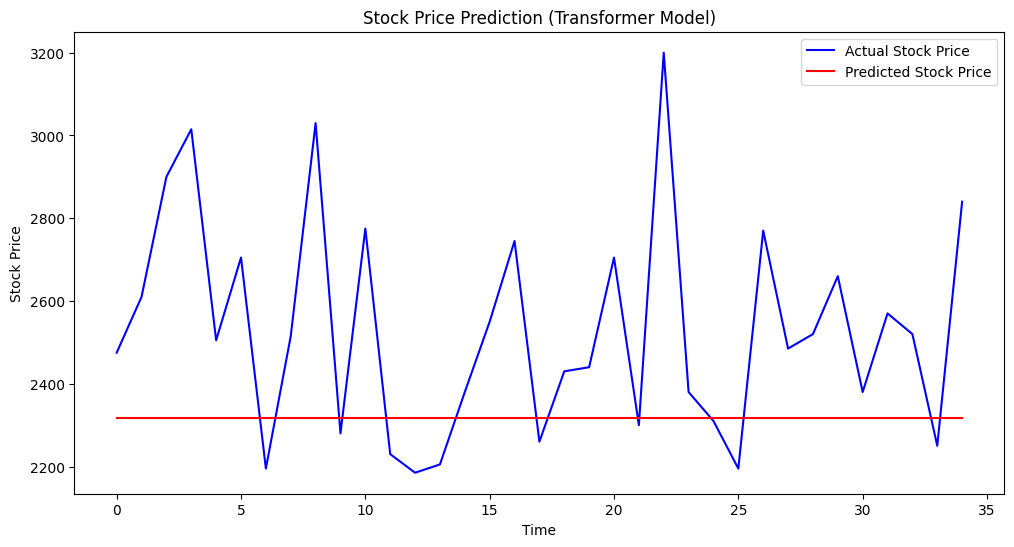

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# 預測測試集
y_pred = model.predict(x_test)
y_pred = scaler.inverse_transform(y_pred)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# 計算 MSE 和 MAE
mse = mean_squared_error(y_test_inverse, y_pred)
mae = mean_absolute_error(y_test_inverse, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')

# 可視化預測結果
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, color='blue', label='Actual Stock Price')
plt.plot(y_pred, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction (Transformer Model)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


### 效果還是不太好，可能30還是太短了，短序列且資料量較少的情況下，還是LSTM更佔優勢